In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/5AH62Uc1VZFh6smQqkt2LzkHGIYl7O-n4f-rHvxgJCVX8vbTsKjmkpU


### **Loading all the required Libraries**

In [ ]:
import time
import os
from tqdm import tqdm
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras as k
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import optuna

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

path = '../input/face-images-with-marked-landmark-points/'

### **Creating Helper Functions**

In [ ]:
def plot_image_landmarks(img_array, df_landmarks, index):
    plt.imshow(img_array[index, :, :, 0], cmap = 'gray')
    plt.scatter(df_landmarks.iloc[index][0: -1: 2], df_landmarks.iloc[index][1: : 2], c = 'y')
    plt.show()

In [ ]:
def gaussian_k(x0, y0, sigma, width, height):
    """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
    """
    x = np.arange(0, width, 1, float) ## (width,)
    y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
    return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

def create_heatmaps(landmarks, height, width, sigma):
    heatmaps = np.zeros(shape = (len(landmarks), height, width, len(landmarks.columns)//2))
    for i, val in enumerate(landmarks.index.values):
        temp = landmarks.iloc[i].values
        
        all_x = temp[0::2]
        all_y = temp[1::2]

        temp_landmarks = list(zip(all_x, all_y))
        
        for j, land in enumerate(temp_landmarks):
            heatmaps[i, :, :, j] = gaussian_k(land[0], land[1], sigma, width, height)
    return np.around(heatmaps, 5)

def visualize_heatmaps(index, heatmaps):
    heat = heatmaps[index]
    plt.figure(figsize = (15, 8))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        sns.heatmap(heat[:, :, i])
    plt.show()

### **Loading the Dataset**

In [ ]:
x = np.load(path + 'face_images.npz')
x = x.get(x.files[0])
x = np.moveaxis(x, -1, 0)
x = x.reshape(x.shape[0], x.shape[1], x.shape[1], 1)

In [ ]:
df = pd.read_csv(path + 'facial_keypoints.csv')
df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [ ]:
df_new = df.dropna()
# df_new = df_new / 96

x_new = x[df_new.index.values, :, :, :]
x_new = x_new / 255

df_new.reset_index(inplace = True, drop = True)

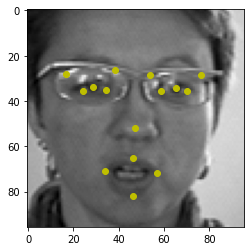

In [ ]:
plot_image_landmarks(x_new, df_new, 10)

### **Generating Heat Maps for the Facial Landmarks using  Gaussian Kernel**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_new, df_new, test_size = 0.1, random_state = 0)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1926, 96, 96, 1), (1926, 30), (214, 96, 96, 1), (214, 30))

In [ ]:
y_train_heatmaps = create_heatmaps(y_train, 96, 96, 5)
y_test_heatmaps = create_heatmaps(y_test, 96, 96, 5)

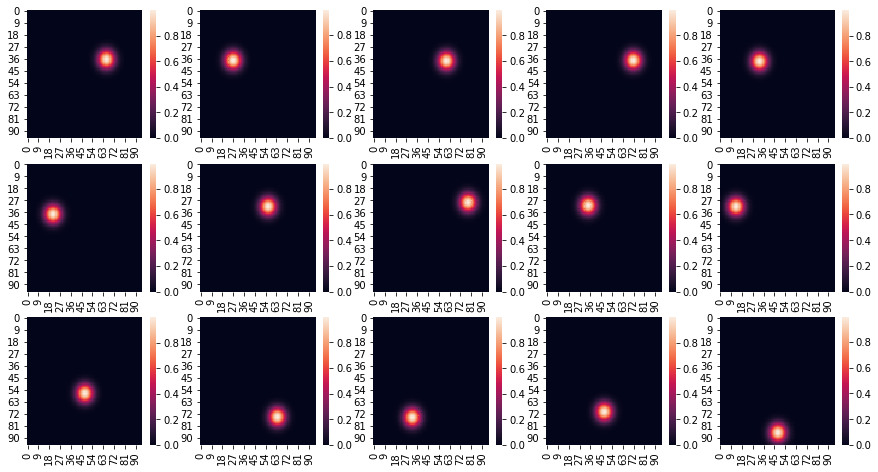

In [ ]:
visualize_heatmaps(10, y_train_heatmaps)

### **Building the model that will be used for training**

In [ ]:
def create_model_heatmaps_1():
    ins = k.Input(shape = x_train.shape[1:])
    
    x = k.layers.Conv2D(256, 7, activation = 'relu', padding = 'same')(ins)
    x = k.layers.BatchNormalization()(x)
    
    x = k.layers.Conv2D(256, 5, activation = 'relu', padding = 'same')(x)
    x = k.layers.BatchNormalization()(x)
    
    x = k.layers.Conv2D(256, 3, activation = 'relu')(x)
    x = k.layers.BatchNormalization()(x)
    
    x = k.layers.Conv2D(128, 3, activation = 'relu')(x)
    x = k.layers.BatchNormalization()(x)
    
    x = k.layers.Conv2D(128, 3, activation = 'relu')(x)
    x = k.layers.Conv2D(128, 3, activation = 'relu')(x)
    x = k.layers.Conv2D(128, 3, activation = 'relu')(x)
    x = k.layers.BatchNormalization()(x)
    
    x = k.layers.MaxPool2D(3)(x)
    
    x = k.layers.Conv2DTranspose(128, 3, activation = 'relu')(x)
    x = k.layers.BatchNormalization()(x)
    
    x = k.layers.Conv2DTranspose(128, 3, activation = 'relu')(x)
    x = k.layers.BatchNormalization()(x)
    
    outs = k.layers.Conv2DTranspose(15, 3, strides = 3, activation = 'sigmoid')(x)
    
    model = k.Model(inputs = ins, outputs = outs)
    opt = k.optimizers.Adam(learning_rate = 0.01)
    model.compile(loss = 'mse', optimizer = opt, metrics = 'mse')
    return model

In [ ]:
model1 = create_model_heatmaps_1()
model1.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 256)       12800     
_________________________________________________________________
batch_normalization_7 (Batch (None, 96, 96, 256)       1024      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 96, 96, 256)       1638656   
_________________________________________________________________
batch_normalization_8 (Batch (None, 96, 96, 256)       1024      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 94, 94, 256)       590080    
_________________________________________________________________
batch_normalization_9 (Batch (None, 94, 94, 256)      

In [ ]:
calls = [k.callbacks.ReduceLROnPlateau(patience = 5, verbose = 1), k.callbacks.EarlyStopping(patience = 10)]
history1 = model1.fit(x = x_train, y = y_train_heatmaps, batch_size = 32, epochs = 100, verbose = 2, validation_data = (x_test, y_test_heatmaps), callbacks = calls)

Epoch 1/100
61/61 - 15s - loss: 0.0569 - mse: 0.0569 - val_loss: 0.3331 - val_mse: 0.3331
Epoch 2/100
61/61 - 14s - loss: 0.0100 - mse: 0.0100 - val_loss: 0.4136 - val_mse: 0.4136
Epoch 3/100
61/61 - 14s - loss: 0.0081 - mse: 0.0081 - val_loss: 0.4042 - val_mse: 0.4042
Epoch 4/100
61/61 - 14s - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0412 - val_mse: 0.0412
Epoch 5/100
61/61 - 14s - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 6/100
61/61 - 14s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 7/100
61/61 - 14s - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 8/100
61/61 - 14s - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 9/100
61/61 - 14s - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 10/100
61/61 - 14s - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 11/100
61/61 - 14s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 12

In [ ]:
model = create_model_heatmaps()
model.summary()

In [ ]:
calls = [k.callbacks.ReduceLROnPlateau(patience = 2), k.callbacks.EarlyStopping(patience = 10)]
history = model.fit(x = x_train, y = y_train_heatmaps, batch_size = 32, epochs = 150, validation_data = (x_test, y_test_heatmaps), callbacks = calls)

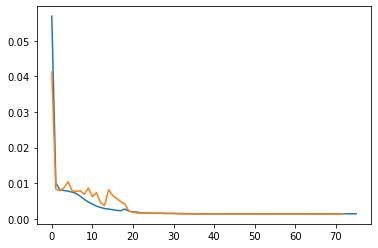

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'][3:])

### **Visualising the results of the Model on random image of the Testing dataset**

In [ ]:
y_pred = model1.predict(x_test)

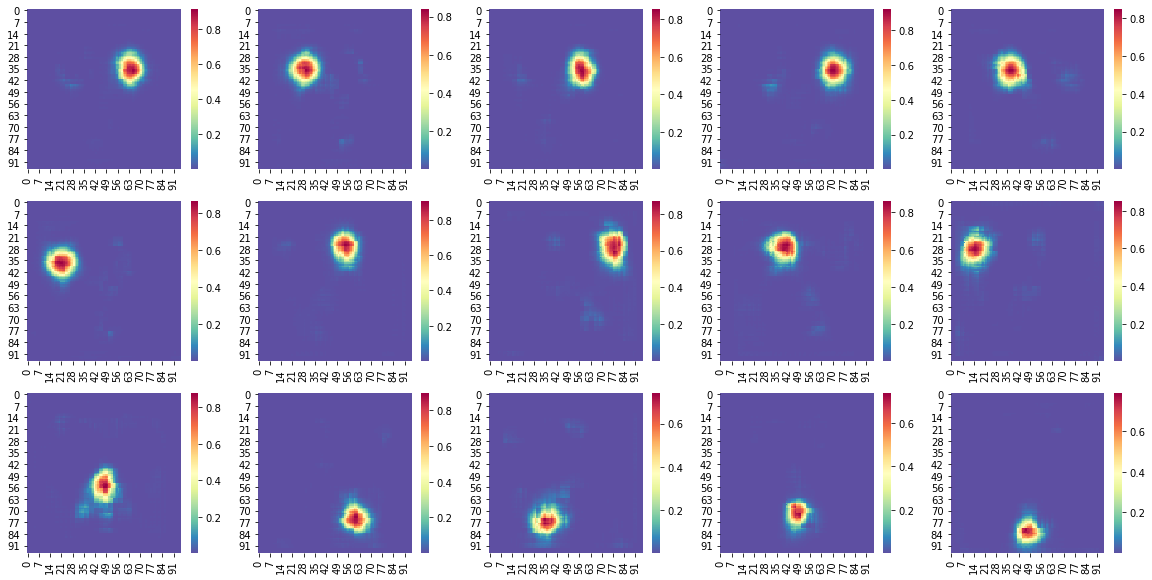

In [ ]:
plt.figure(figsize = (20, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    sns.heatmap(y_pred[4, :, :, i], cmap = 'Spectral_r')
plt.show()

As it may be observed, the model can localise very nicely on the various landmarks on the face.

In [ ]:
def find_xy(heatmap, n):
    top_n = np.sort(heatmap.flatten())[-n:]
    top_n_locs = [np.where(heatmap == i) for i in top_n]
    top_n_locs = np.array([np.array([i[0][0], i[1][0]]) for i in top_n_locs])
    norm_top_n = top_n / np.max(top_n)
    
    y = np.sum(top_n_locs[:, 0] * norm_top_n)/np.sum(norm_top_n)
    x = np.sum(top_n_locs[:, 1] * norm_top_n)/np.sum(norm_top_n)
    
    return np.array([x, y])

def get_landmarks(predictions, n):
    landmarks = []
    
    for i, val in enumerate(predictions):
        lands = []
        for j in range(val.shape[-1]):
            xy = find_xy(predictions[i, :, :, j], n=6)
            lands.append(xy)
        landmarks.append(np.array(lands))
    landmarks = np.array(landmarks)
    landmarks = landmarks.reshape(landmarks.shape[0], -1)
    return landmarks

In [ ]:
landmarks_pred = get_landmarks(y_pred, 5)

In [ ]:
landmarks_pred

array([[64.83377962, 37.32491666, 33.66467523, ..., 64.68573161,
        53.18165791, 72.32282506],
       [68.83836911, 38.32846498, 28.50202357, ..., 73.16805638,
        45.99769959, 87.49455272],
       [66.16597485, 35.83085079, 24.16697727, ..., 75.65110349,
        45.49636567, 85.00712031],
       ...,
       [67.16490199, 34.66890712, 28.50349488, ..., 72.32653148,
        49.18193109, 79.34827377],
       [66.66561622, 37.83218581, 28.50089191, ..., 70.00382026,
        46.5093691 , 81.99963692],
       [69.66277075, 37.83187779, 28.8324328 , ..., 77.33127882,
        55.51735492, 82.99999748]])

In [ ]:
def plot_img_preds(images, truth, pred, index):
    plt.imshow(images[index, :, :, 0], cmap = 'gray')
    
    t = np.array(truth)[index]
    plt.scatter(t[0::2], t[1::2], c = 'y')
    
    p = pred[index, :]
    plt.scatter(p[0::2], p[1::2], c = 'r')
    
    plt.show()

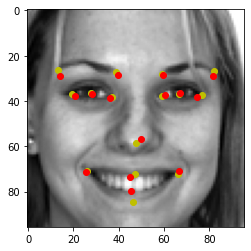

In [ ]:
plot_img_preds(x_test, y_test, landmarks_pred, 7)

The above image is just an example to show how good the landmark recognition model is. This model will now be used to create a Snapchat/Instagram style filter that replaces a person's nose with a Pig's nose emoji.